In [13]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import ast
import warnings

In [14]:
# Cell 2: Load and parse raw Google cluster data
# Load the CSV
df_raw = pd.read_csv('data/df_cleaned.csv')

print(f"Raw data shape: {df_raw.shape}")
print(f"\nFirst few rows:")
print(df_raw.head())

# Parse the average_usage column (it's a string representation of a dict)
def parse_usage(usage_str):
    """Parse the string representation of usage dict"""
    try:
        usage_dict = ast.literal_eval(usage_str)
        return usage_dict['cpus'], usage_dict['memory']
    except:
        return None, None

# Extract CPU and memory
df_raw[['cpu', 'memory']] = df_raw['average_usage'].apply(
    lambda x: pd.Series(parse_usage(x))
)

# CRITICAL FIX: Timestamps are relative microseconds from trace start (NOT Unix epoch!)
# According to the PDF (page 2): "timestamp, which is in microseconds since 600 seconds 
# before the beginning of the trace period"
# We'll just use the relative timestamps as-is for ordering
df_raw['time_us'] = df_raw['time'].astype(np.int64)  # Keep as microseconds for ordering

# Drop rows with missing values
df_raw = df_raw.dropna()

print(f"\nAfter parsing:")
print(f"Shape: {df_raw.shape}")
print(f"\nParsed columns:")
print(df_raw[['time_us', 'cpu', 'memory']].head(10))
print(f"\nData types:")
print(df_raw[['time_us', 'cpu', 'memory']].dtypes)
print(f"\nBasic statistics:")
print(df_raw[['cpu', 'memory']].describe())
print(f"\nTime range (microseconds):")
print(f"  Min: {df_raw['time_us'].min()}")
print(f"  Max: {df_raw['time_us'].max()}")
print(f"  Span: {(df_raw['time_us'].max() - df_raw['time_us'].min()) / 1e6 / 3600:.2f} hours")

Raw data shape: (9828, 2)

First few rows:
           time                                      average_usage
0  1.454560e+12  {'cpus': 0.00020599365234375, 'memory': 0.0015...
1  1.454560e+12  {'cpus': 0.00020599365234375, 'memory': 0.0015...
2  1.454560e+12  {'cpus': 0.00020599365234375, 'memory': 0.0015...
3  1.454560e+12  {'cpus': 0.00020599365234375, 'memory': 0.0015...
4  1.454560e+12  {'cpus': 0.00020599365234375, 'memory': 0.0015...

After parsing:
Shape: (9828, 5)

Parsed columns:
         time_us       cpu    memory
0  1454560000000  0.000206  0.001535
1  1454560000000  0.000206  0.001535
2  1454560000000  0.000206  0.001535
3  1454560000000  0.000206  0.001535
4  1454560000000  0.000206  0.001535
5  1454560000000  0.000206  0.001535
6  1454560000000  0.000206  0.001535
7  1454560000000  0.000206  0.001535
8  1454560000000  0.000206  0.001535
9  1454560000000  0.000206  0.001535

Data types:
time_us      int64
cpu        float64
memory     float64
dtype: object

Basic statist

Total rows: 9828
Unique timestamps: 359
Duplicate timestamps: 9469

After aggregation:
Total rows: 359

Time interval statistics (in seconds):
count    358.000000
mean      14.413408
std       35.283042
min       10.000000
25%       10.000000
50%       10.000000
75%       10.000000
max      570.000000
Name: time_diff_seconds, dtype: float64

Most common interval: [10.]
Intervals close to 5 minutes (300s ± 60s): 1/358


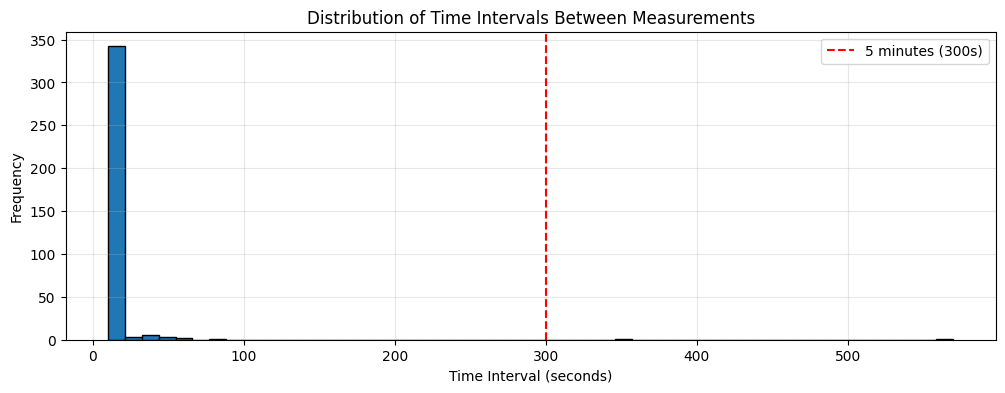


Clean DataFrame shape: (359, 3)
Time range (microseconds): 1454560000000 to 1459720000000
Duration: 1.43 hours

First few rows of clean data:
         time_us       cpu    memory
0  1454560000000  0.000206  0.001535
1  1454570000000  0.000206  0.001535
2  1454580000000  0.000206  0.001535
3  1454590000000  0.000206  0.001535
4  1454600000000  0.000206  0.001535
5  1454610000000  0.000206  0.001535
6  1454620000000  0.000206  0.001535
7  1454630000000  0.000206  0.001535
8  1454640000000  0.000206  0.001535
9  1454650000000  0.000206  0.001535


In [15]:
# Cell 3: Handle duplicates and verify time intervals
# Select only the columns we need
df = df_raw[['time_us', 'cpu', 'memory']].copy()

# Check for duplicate timestamps
print(f"Total rows: {len(df)}")
print(f"Unique timestamps: {df['time_us'].nunique()}")
print(f"Duplicate timestamps: {len(df) - df['time_us'].nunique()}")

# Aggregate duplicates by taking the mean
df_agg = df.groupby('time_us').agg({
    'cpu': 'mean',
    'memory': 'mean'
}).reset_index()

# Sort by time
df_agg = df_agg.sort_values('time_us').reset_index(drop=True)

print(f"\nAfter aggregation:")
print(f"Total rows: {len(df_agg)}")

# Check time intervals (convert microseconds to seconds)
df_agg['time_diff_us'] = df_agg['time_us'].diff()
df_agg['time_diff_seconds'] = df_agg['time_diff_us'] / 1e6  # Convert to seconds

print(f"\nTime interval statistics (in seconds):")
print(df_agg['time_diff_seconds'].describe())
print(f"\nMost common interval: {df_agg['time_diff_seconds'].mode().values}")

# Check how many are close to 300 seconds (5 minutes)
five_min_tolerance = 60  # 1 minute tolerance
five_min_count = ((df_agg['time_diff_seconds'] >= 300 - five_min_tolerance) & 
                  (df_agg['time_diff_seconds'] <= 300 + five_min_tolerance)).sum()
print(f"Intervals close to 5 minutes (300s ± {five_min_tolerance}s): {five_min_count}/{len(df_agg)-1}")

# Visualize time intervals
plt.figure(figsize=(12, 4))
plt.hist(df_agg['time_diff_seconds'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Time Interval (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Intervals Between Measurements')
plt.axvline(x=300, color='r', linestyle='--', label='5 minutes (300s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Drop the time_diff columns (no longer needed)
df_clean = df_agg.drop(columns=['time_diff_us', 'time_diff_seconds'])

print(f"\nClean DataFrame shape: {df_clean.shape}")
print(f"Time range (microseconds): {df_clean['time_us'].min()} to {df_clean['time_us'].max()}")
print(f"Duration: {(df_clean['time_us'].max() - df_clean['time_us'].min()) / 1e6 / 3600:.2f} hours")
print(f"\nFirst few rows of clean data:")
print(df_clean.head(10))

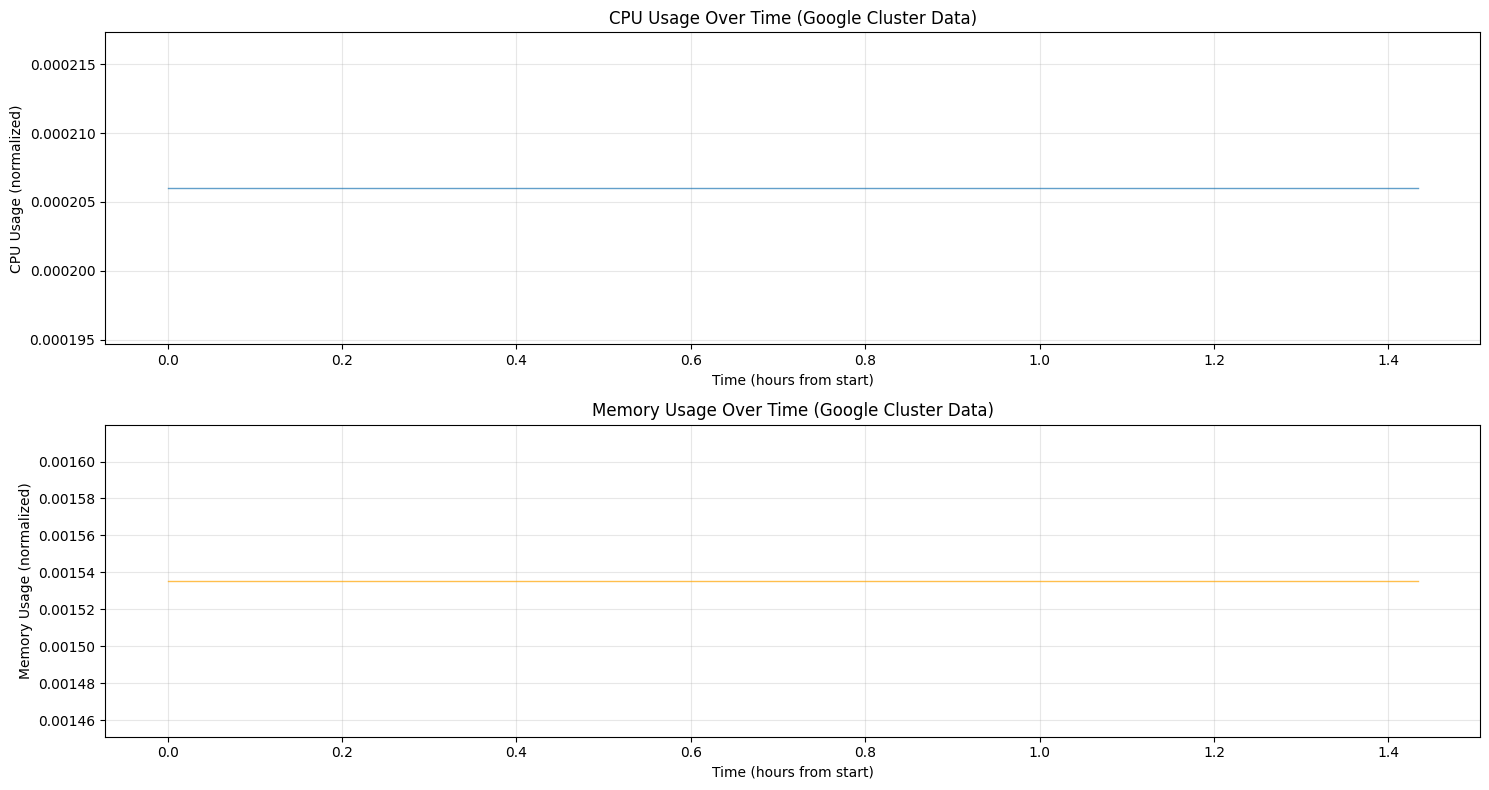

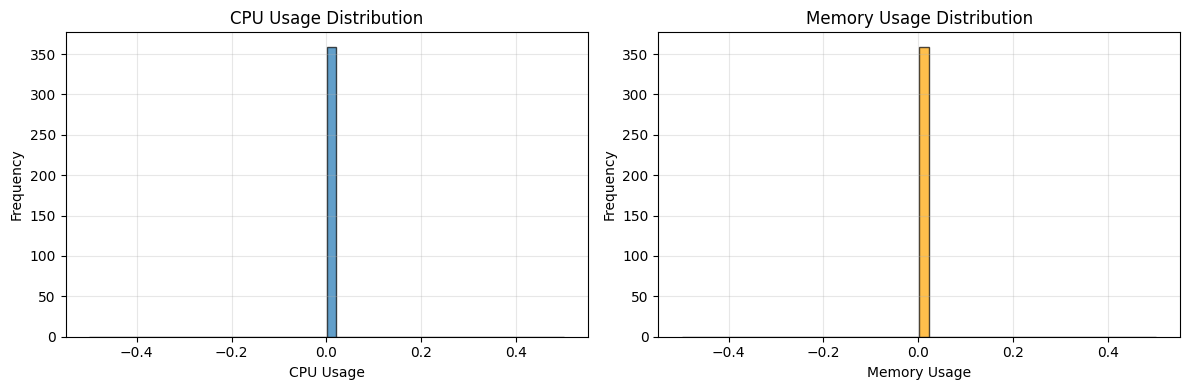

CPU - Min: 0.000206, Max: 0.000206, Mean: 0.000206
Memory - Min: 0.001535, Max: 0.001535, Mean: 0.001535


In [16]:
# Cell 4: Visualize raw time series data
# For visualization, we'll use index as a proxy for time progression
# (since timestamps are relative microseconds, not absolute datetimes)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Convert relative time to hours for better x-axis labels
time_hours = (df_clean['time_us'] - df_clean['time_us'].min()) / 1e6 / 3600

# Plot CPU usage over time
axes[0].plot(time_hours, df_clean['cpu'], linewidth=1, alpha=0.7)
axes[0].set_xlabel('Time (hours from start)')
axes[0].set_ylabel('CPU Usage (normalized)')
axes[0].set_title('CPU Usage Over Time (Google Cluster Data)')
axes[0].grid(True, alpha=0.3)

# Plot memory usage over time
axes[1].plot(time_hours, df_clean['memory'], linewidth=1, alpha=0.7, color='orange')
axes[1].set_xlabel('Time (hours from start)')
axes[1].set_ylabel('Memory Usage (normalized)')
axes[1].set_title('Memory Usage Over Time (Google Cluster Data)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show data distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_clean['cpu'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('CPU Usage')
axes[0].set_ylabel('Frequency')
axes[0].set_title('CPU Usage Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_clean['memory'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Memory Usage')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Memory Usage Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CPU - Min: {df_clean['cpu'].min():.6f}, Max: {df_clean['cpu'].max():.6f}, Mean: {df_clean['cpu'].mean():.6f}")
print(f"Memory - Min: {df_clean['memory'].min():.6f}, Max: {df_clean['memory'].max():.6f}, Mean: {df_clean['memory'].mean():.6f}")

In [17]:
# Cell 5: Apply MinMaxScaler normalization
# Extract features (CPU and memory)
features = df_clean[['cpu', 'memory']].values

print(f"Features shape before normalization: {features.shape}")
print(f"Sample values (first 5):")
print(features[:5])

# Apply MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

print(f"\nFeatures shape after normalization: {features_normalized.shape}")
print(f"Normalized data range:")
print(f"  CPU: [{features_normalized[:, 0].min():.4f}, {features_normalized[:, 0].max():.4f}]")
print(f"  Memory: [{features_normalized[:, 1].min():.4f}, {features_normalized[:, 1].max():.4f}]")
print(f"\nSample normalized values (first 5):")
print(features_normalized[:5])

# Save the scaler for later use (denormalization during inference)
import pickle
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nScaler saved to data/scaler.pkl")

Features shape before normalization: (359, 2)
Sample values (first 5):
[[0.00020599 0.00153542]
 [0.00020599 0.00153542]
 [0.00020599 0.00153542]
 [0.00020599 0.00153542]
 [0.00020599 0.00153542]]

Features shape after normalization: (359, 2)
Normalized data range:
  CPU: [0.0000, 0.0000]
  Memory: [0.0000, 0.0000]

Sample normalized values (first 5):
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Scaler saved to data/scaler.pkl


In [18]:
# Cell 6: Create 30-min sequences (6 timesteps = 30 min)
def create_sequences(data, seq_length=6):
    """
    Create sliding window sequences for time series prediction.
    
    Args:
        data: Normalized feature array (n_samples, n_features)
        seq_length: Number of timesteps in each sequence (default: 6 for 30 min)
    
    Returns:
        X: Input sequences (n_sequences, seq_length, n_features)
        y: Target values (n_sequences, n_features)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Input: 6 timesteps of [cpu, memory]
        X.append(data[i:i + seq_length])
        # Target: Next timestep [cpu, memory]
        y.append(data[i + seq_length])
    
    return np.array(X), np.array(y)

# Create sequences
SEQ_LENGTH = 6  # 6 timesteps × 5 min = 30 min lookback
X, y = create_sequences(features_normalized, seq_length=SEQ_LENGTH)

print(f"Input sequences shape: {X.shape}")  # (n_sequences, 6, 2)
print(f"Target values shape: {y.shape}")    # (n_sequences, 2)
print(f"\nTotal sequences created: {len(X)}")
print(f"Each sequence has {SEQ_LENGTH} timesteps with {X.shape[2]} features (CPU, Memory)")

# Show a sample sequence
print(f"\n=== Sample Sequence (first) ===")
print(f"Input shape: {X[0].shape}")
print(f"Input (6 timesteps of [cpu, memory]):")
print(X[0])
print(f"\nTarget (next timestep [cpu, memory]): {y[0]}")

# Calculate how much data we have in days
total_minutes = len(X) * 5  # Each sequence represents 5 minutes
total_hours = total_minutes / 60
total_days = total_hours / 24
print(f"\n=== Data Coverage ===")
print(f"Total data span: ~{total_days:.1f} days ({total_hours:.1f} hours, {total_minutes} minutes)")

Input sequences shape: (353, 6, 2)
Target values shape: (353, 2)

Total sequences created: 353
Each sequence has 6 timesteps with 2 features (CPU, Memory)

=== Sample Sequence (first) ===
Input shape: (6, 2)
Input (6 timesteps of [cpu, memory]):
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Target (next timestep [cpu, memory]): [0. 0.]

=== Data Coverage ===
Total data span: ~1.2 days (29.4 hours, 1765 minutes)


In [19]:
# Cell 7: Train/Test split (chronological for time series)
# Use chronological split (CRITICAL for time series!)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"=== Train/Test Split ===")
print(f"Train set: {X_train.shape[0]} sequences ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} sequences ({X_test.shape[0]/len(X)*100:.1f}%)")

# Calculate time coverage
train_days = (X_train.shape[0] * 5) / (60 * 24)
test_days = (X_test.shape[0] * 5) / (60 * 24)
print(f"\nTrain data: ~{train_days:.1f} days")
print(f"Test data: ~{test_days:.1f} days")

print(f"\n=== Data Shapes ===")
print(f"X_train: {X_train.shape}  # (samples, 6 timesteps, 2 features)")
print(f"y_train: {y_train.shape}  # (samples, 2 features)")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Verify data integrity
print(f"\n=== Data Integrity Check ===")
print(f"X_train - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"y_train - Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"X_test - Min: {X_test.min():.4f}, Max: {X_test.max():.4f}")
print(f"y_test - Min: {y_test.min():.4f}, Max: {y_test.max():.4f}")
print(f"No NaN values: {not (np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any())}")

=== Train/Test Split ===
Train set: 282 sequences (79.9%)
Test set: 71 sequences (20.1%)

Train data: ~1.0 days
Test data: ~0.2 days

=== Data Shapes ===
X_train: (282, 6, 2)  # (samples, 6 timesteps, 2 features)
y_train: (282, 2)  # (samples, 2 features)
X_test: (71, 6, 2)
y_test: (71, 2)

=== Data Integrity Check ===
X_train - Min: 0.0000, Max: 0.0000
y_train - Min: 0.0000, Max: 0.0000
X_test - Min: 0.0000, Max: 0.0000
y_test - Min: 0.0000, Max: 0.0000
No NaN values: True


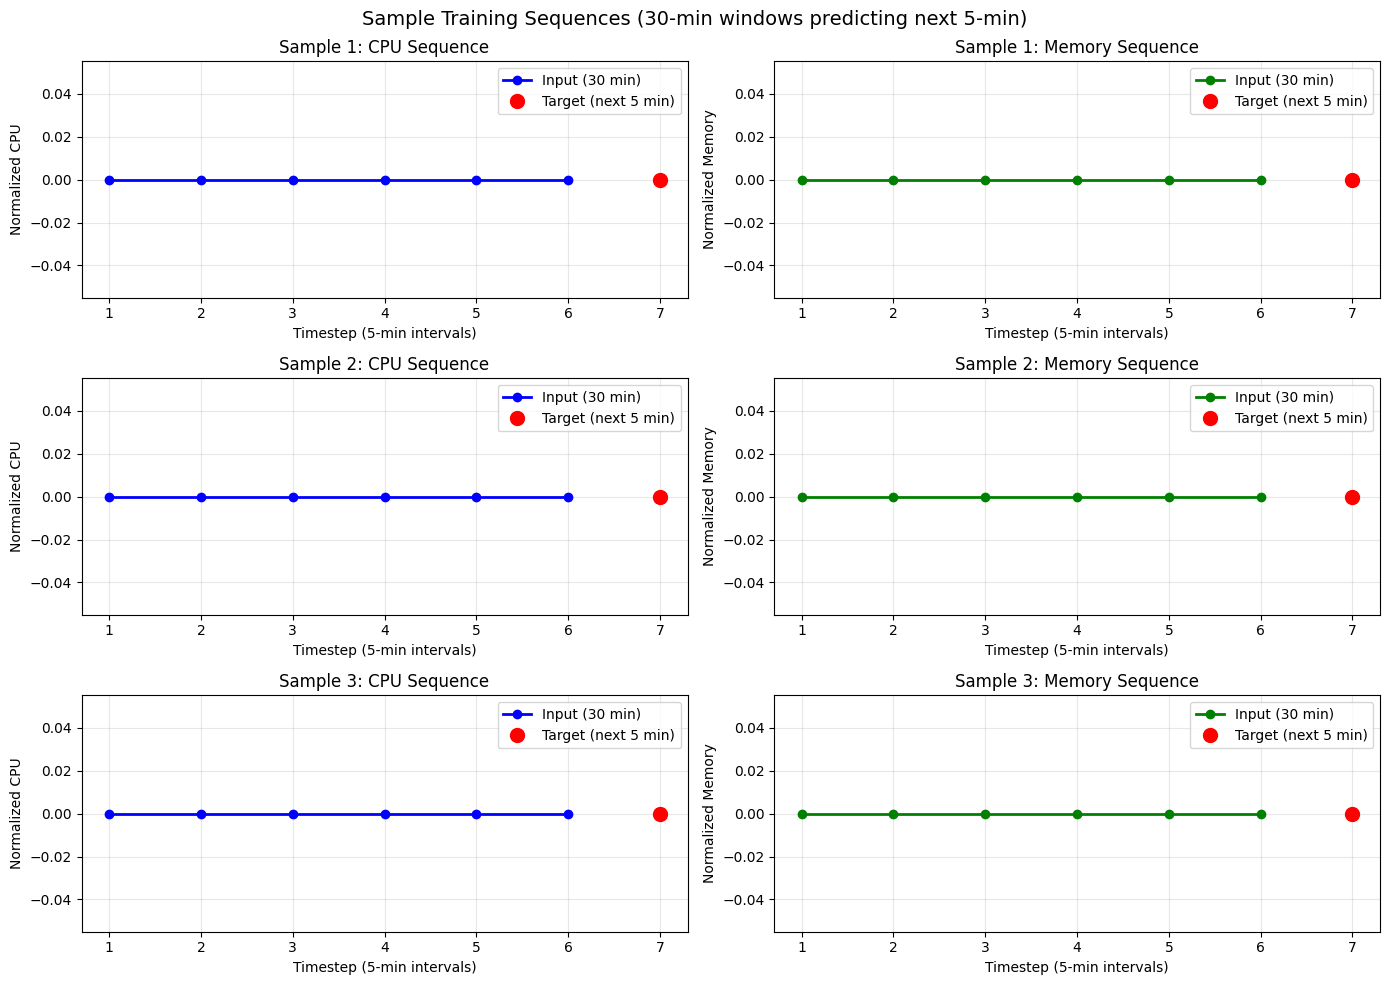

✓ Sequences visualized successfully
  - Blue line: 30-minute input window (6 timesteps)
  - Red dot: Target prediction (next 5 minutes)


In [20]:
# Cell 8: Visualize sample sequences
# Visualize a few sample sequences to verify they make sense

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Sample Training Sequences (30-min windows predicting next 5-min)', fontsize=14)

# Show 3 random sequences
sample_indices = np.random.choice(len(X_train), 3, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    # CPU subplot
    axes[idx, 0].plot(range(1, 7), X_train[sample_idx][:, 0], 'b-o', label='Input (30 min)', linewidth=2)
    axes[idx, 0].plot(7, y_train[sample_idx][0], 'ro', markersize=10, label='Target (next 5 min)')
    axes[idx, 0].set_xlabel('Timestep (5-min intervals)')
    axes[idx, 0].set_ylabel('Normalized CPU')
    axes[idx, 0].set_title(f'Sample {idx+1}: CPU Sequence')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].set_xticks(range(1, 8))
    
    # Memory subplot
    axes[idx, 1].plot(range(1, 7), X_train[sample_idx][:, 1], 'g-o', label='Input (30 min)', linewidth=2)
    axes[idx, 1].plot(7, y_train[sample_idx][1], 'ro', markersize=10, label='Target (next 5 min)')
    axes[idx, 1].set_xlabel('Timestep (5-min intervals)')
    axes[idx, 1].set_ylabel('Normalized Memory')
    axes[idx, 1].set_title(f'Sample {idx+1}: Memory Sequence')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].set_xticks(range(1, 8))

plt.tight_layout()
plt.show()

print("✓ Sequences visualized successfully")
print("  - Blue line: 30-minute input window (6 timesteps)")
print("  - Red dot: Target prediction (next 5 minutes)")

In [21]:
# Cell 9: Save processed data for training
# Save the processed data as numpy arrays
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)

print("✓ Processed data saved successfully!")
print("\nSaved files:")
print("  - data/X_train.npy")
print("  - data/y_train.npy")
print("  - data/X_test.npy")
print("  - data/y_test.npy")
print("  - data/scaler.pkl (for denormalization)")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE")
print("="*60)
print("\nData is ready for training!")
print(f"\nFinal shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print("\nNext steps:")
print("  1. Open training.ipynb")
print("  2. Load the data using:")
print("     X_train = np.load('data/X_train.npy')")
print("     y_train = np.load('data/y_train.npy')")
print("     X_test = np.load('data/X_test.npy')")
print("     y_test = np.load('data/y_test.npy')")
print("  3. Convert to PyTorch tensors and train the model!")

✓ Processed data saved successfully!

Saved files:
  - data/X_train.npy
  - data/y_train.npy
  - data/X_test.npy
  - data/y_test.npy
  - data/scaler.pkl (for denormalization)

PREPROCESSING COMPLETE

Data is ready for training!

Final shapes:
  X_train: (282, 6, 2)
  y_train: (282, 2)
  X_test: (71, 6, 2)
  y_test: (71, 2)

Next steps:
  1. Open training.ipynb
  2. Load the data using:
     X_train = np.load('data/X_train.npy')
     y_train = np.load('data/y_train.npy')
     X_test = np.load('data/X_test.npy')
     y_test = np.load('data/y_test.npy')
  3. Convert to PyTorch tensors and train the model!
